## Load required libraries and data

`data.table` (fread) used to read the data source instead of `data.frame` (read.csv) as it reads the data faster.

In [36]:
library(data.table)
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(corrplot)
library(randomForest)

require(scales) # to access break formatting functions

listings <- fread("resources/airbnb_data/listings.csv.gz")
neighbourhoods <- fread("resources/airbnb_data/neighbourhoods.csv")
reviews <- fread("resources/airbnb_data/reviews.csv")

## Data Visualisation

### Data Preprocessing

- First course of action was to represent the data in the data table. 
- Then the next step involved removing columns from the table that were not considered as required for the exploration process.
- After removing the "excess columns", it was necessary to prepare the data for exploration, visualisation and correlation as they are required to train the data and build the model.

In [37]:
listings_dt <- as.data.table(listings)
neighbourhoods_dt <- as.data.table(neighbourhoods)
reviews_dt <- as.data.table(reviews)

In [38]:
listings_dt_trim <- listings_dt[, c("listing_url", "scrape_id", "last_scraped", "source", "name", "description", "neighborhood_overview", "picture_url", "host_id", "host_url", "host_location", "host_about", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_listings_count", "host_total_listings_count", "host_verifications", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms", "amenities", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "calendar_updated", "has_availability", "calendar_last_scraped", "number_of_reviews_ltm", "number_of_reviews_l30d", "first_review", "last_review", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "license", "instant_bookable", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms") := NULL] # nolint

In [39]:
corr_listings_dt <- listings_dt_trim[, c("id", "host_name", "host_since", "host_has_profile_pic", "host_identity_verified", "bedrooms", "beds", "host_response_time", "host_response_rate", "host_acceptance_rate", "property_type", "bathrooms_text", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "availability_30", "availability_60", "availability_365", "reviews_per_month", "review_scores_rating") := NULL] # nolint

### Data Preprocessing (contd.)

- Considering the fact that the feature to be predicted is the Quarterly Revenue.
- Categorical data also had to be properly represented for the sake of proper analysis.
- Checks were done to view the data structure.
- Dataset was cleaned.

In [40]:
# represent superhost as binary (because it was "t" or "f")
corr_listings_dt[, ":=" (host_is_superhost = ifelse(host_is_superhost == "f",0,1))] # nolint

# remove symbol from price(currency) column
cols <- names(corr_listings_dt)
corr_listings_dt[, (cols) := lapply(.SD, function(x) gsub("\\$", "", x)), .SDcols = cols] # nolint
corr_listings_dt <- type.convert(corr_listings_dt, as.is = TRUE)

# represent categorical data - room_type as number
corr_listings_dt$room_type[corr_listings_dt$room_type == "Private room"] <- 1
corr_listings_dt$room_type[corr_listings_dt$room_type == "Entire home/apt"] <- 2
corr_listings_dt$room_type[corr_listings_dt$room_type == "Hotel room"] <- 3
corr_listings_dt$room_type[corr_listings_dt$room_type == "Shared room"] <- 4

# represent categorical data - neighbourhood as number
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Wandsworth"] <- 1 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Hammersmith and Fulham"] <- 2 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Islington"] <- 3 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Kensington and Chelsea"] <- 4 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Greenwich"] <- 5 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Westminster"] <- 6 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Tower Hamlets"] <- 7 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Barnet"] <- 8 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Lewisham"] <- 9 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Brent"] <- 10 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Richmond upon Thames"] <- 11 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Haringey"] <- 12 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Southwark"] <- 13 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Enfield"] <- 14 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Hounslow"] <- 15 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Camden"] <- 16 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Waltham Forest"] <- 17 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "City of London"] <- 18 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Hackney"] <- 19 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Ealing"] <- 20 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Croydon"] <- 21 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Merton"] <- 22 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Havering"] <- 23 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Harrow"] <- 24 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Newham"] <- 25 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Hillingdon"] <- 26 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Barking and Dagenham"] <- 27 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Bromley"] <- 28 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Kingston upon Thames"] <- 29 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Redbridge"] <- 30 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Bexley"] <- 31 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Sutton"] <- 32 # nolint
corr_listings_dt$neighbourhood_cleansed[corr_listings_dt$neighbourhood_cleansed == "Lambeth"] <- 33 # nolint

# ensure data classes are as required
corr_listings_dt <- corr_listings_dt[, price := as.numeric(price)]
corr_listings_dt <- corr_listings_dt[, room_type := as.numeric(room_type)]
corr_listings_dt <- corr_listings_dt[, neighbourhood_cleansed := as.numeric(neighbourhood_cleansed)] # nolint

head(corr_listings_dt)

Warning message in eval(jsub, SDenv, parent.frame()):
"NAs introduced by coercion"


host_is_superhost neighbourhood_cleansed latitude longitude room_type
1 0                 1                      51.44201 -0.18739  1        
2 0                 2                      51.49993 -0.21707  2        
3 0                 3                      51.56861 -0.11270  1        
4 0                 4                      51.48780 -0.16813  2        
5 1                 5                      51.47618  0.01442  1        
6 1                 6                      51.52195 -0.14094  2        
  accommodates price minimum_nights maximum_nights availability_90
1 2             42   2              730             0             
2 5            175   5              240            38             
3 1             79   1               29            85             
4 2            150   7               30             7             
5 2             46   4              365             5             
6 6            476   3              365            50             
  number_of_reviews
1 216              
2  38              
3  41              
4  94              
5 180              
6  54

In [41]:
# clean the dataset
corr_listings_dt <- corr_listings_dt %>%
  filter(!is.na(price)) %>%
  select(host_is_superhost, neighbourhood_cleansed, latitude, longitude, room_type, accommodates, price, minimum_nights, maximum_nights, availability_90, number_of_reviews) # nolint

In [42]:
# perform checks on the dataset to ensure it is clean and there are no null values # nolint
str(corr_listings_dt)
summary(corr_listings_dt)
unique(corr_listings_dt$accommodates)
subset(corr_listings_dt, (neighbourhood_cleansed == "30"))
colSums(is.na(corr_listings_dt))

Classes 'data.table' and 'data.frame':	86152 obs. of  11 variables:
 $ host_is_superhost     : int  0 0 0 0 1 1 1 0 0 0 ...
 $ neighbourhood_cleansed: num  1 2 3 4 5 6 6 1 7 8 ...
 $ latitude              : num  51.4 51.5 51.6 51.5 51.5 ...
 $ longitude             : num  -0.1874 -0.2171 -0.1127 -0.1681 0.0144 ...
 $ room_type             : num  1 2 1 2 1 2 2 2 2 1 ...
 $ accommodates          : int  2 5 1 2 2 6 4 3 4 2 ...
 $ price                 : num  42 175 79 150 46 476 371 250 75 29 ...
 $ minimum_nights        : int  2 5 1 7 4 3 5 2 2 10 ...
 $ maximum_nights        : int  730 240 29 30 365 365 365 1125 14 1120 ...
 $ availability_90       : int  0 38 85 7 5 50 86 0 0 0 ...
 $ number_of_reviews     : int  216 38 41 94 180 54 24 96 42 129 ...
 - attr(*, ".internal.selfref")=<externalptr> 


 host_is_superhost neighbourhood_cleansed    latitude       longitude       
 Min.   :0.0000    Min.   : 1.00          Min.   :51.30   Min.   :-0.49780  
 1st Qu.:0.0000    1st Qu.: 6.00          1st Qu.:51.48   1st Qu.:-0.18938  
 Median :0.0000    Median :10.00          Median :51.51   Median :-0.12545  
 Mean   :0.1639    Mean   :12.57          Mean   :51.51   Mean   :-0.12730  
 3rd Qu.:0.0000    3rd Qu.:19.00          3rd Qu.:51.54   3rd Qu.:-0.06724  
 Max.   :1.0000    Max.   :33.00          Max.   :51.68   Max.   : 0.29573  
   room_type      accommodates        price     minimum_nights    
 Min.   :1.000   Min.   : 1.000   Min.   :  0   Min.   :   1.000  
 1st Qu.:1.000   1st Qu.: 2.000   1st Qu.: 61   1st Qu.:   1.000  
 Median :2.000   Median : 2.000   Median :107   Median :   2.000  
 Mean   :1.639   Mean   : 3.145   Mean   :147   Mean   :   5.589  
 3rd Qu.:2.000   3rd Qu.: 4.000   3rd Qu.:185   3rd Qu.:   4.000  
 Max.   :4.000   Max.   :16.000   Max.   :999   Max.   :112

[1]  2  5  1  6  4  3  8  7 12 10 13  9 14 11 16 15

host_is_superhost neighbourhood_cleansed latitude longitude  room_type
1   0                 30                     51.61587 0.04680000 1        
2   0                 30                     51.59075 0.08111000 1        
3   0                 30                     51.55981 0.03933000 1        
4   0                 30                     51.56615 0.02639000 2        
5   0                 30                     51.57392 0.08772000 1        
6   0                 30                     51.56988 0.07772019 1        
7   0                 30                     51.57779 0.11625000 1        
8   0                 30                     51.59160 0.01425000 1        
9   0                 30                     51.57480 0.02962000 2        
10  0                 30                     51.60066 0.03670000 2        
11  0                 30                     51.61281 0.04213000 1        
12  1                 30                     51.56872 0.06540000 1        
13  1                 30                     51.57565 0.02145000 1        
14  0                 30                     51.56097 0.07602000 2        
15  0                 30                     51.55728 0.01959000 1        
16  0                 30                     51.58769 0.02242000 1        
17  0                 30                     51.57844 0.11996000 1        
18  0                 30                     51.55230 0.09774000 1        
19  0                 30                     51.55859 0.09906000 1        
20  0                 30                     51.57081 0.11244000 1        
21  1                 30                     51.56858 0.06450000 1        
22  0                 30                     51.57446 0.08964000 1        
23  0                 30                     51.59081 0.02911000 2        
24  0                 30                     51.57273 0.08951000 1        
25  0                 30                     51.56133 0.07577000 2        
26  1                 30                     51.56465 0.02311000 1        
27  0                 30                     51.56252 0.03975000 2        
28  0                 30                     51.56122 0.07611000 2        
29  1                 30                     51.58593 0.03181000 1        
30  0                 30                     51.59080 0.02900000 2        
... ...               ...                    ...      ...        ...      
838 0                 30                     51.59715 0.02606806 1        
839 0                 30                     51.56140 0.01447000 1        
840 0                 30                     51.57250 0.06531198 2        
841 0                 30                     51.56391 0.10465280 1        
842 0                 30                     51.59013 0.05280165 1        
843 0                 30                     51.56277 0.11251226 1        
844 1                 30                     51.59389 0.02503158 2        
845 1                 30                     51.56032 0.07498000 2        
846 0                 30                     51.58002 0.02650000 2        
847 0                 30                     51.61243 0.10525815 2        
848 0                 30                     51.61485 0.03523688 1        
849 0                 30                     51.60050 0.08989196 2        
850 0                 30                     51.56263 0.07771366 1        
851 0                 30                     51.57497 0.08601940 2        
852 0                 30                     51.60180 0.03341000 1        
853 0                 30                     51.60181 0.03347000 1        
854 0                 30                     51.57037 0.09067547 2        
855 0                 30                     51.58010 0.06362000 1        
856 0                 30                     51.57861 0.06542063 1        
857 0                 30                     51.56427 0.08029110 1        
858 0                 30                     51.57894 0.06364276 1        
859 0                 30     

host_is_superhost neighbourhood_cleansed               latitude 
                     0                      0                      0 
             longitude              room_type           accommodates 
                     0                      0                      0 
                 price         minimum_nights         maximum_nights 
                     0                      0                      0 
       availability_90      number_of_reviews 
                     0                      0

### Data Exploration

- Plots of the features of the dataset to get some intuitive knowledge about the dataset

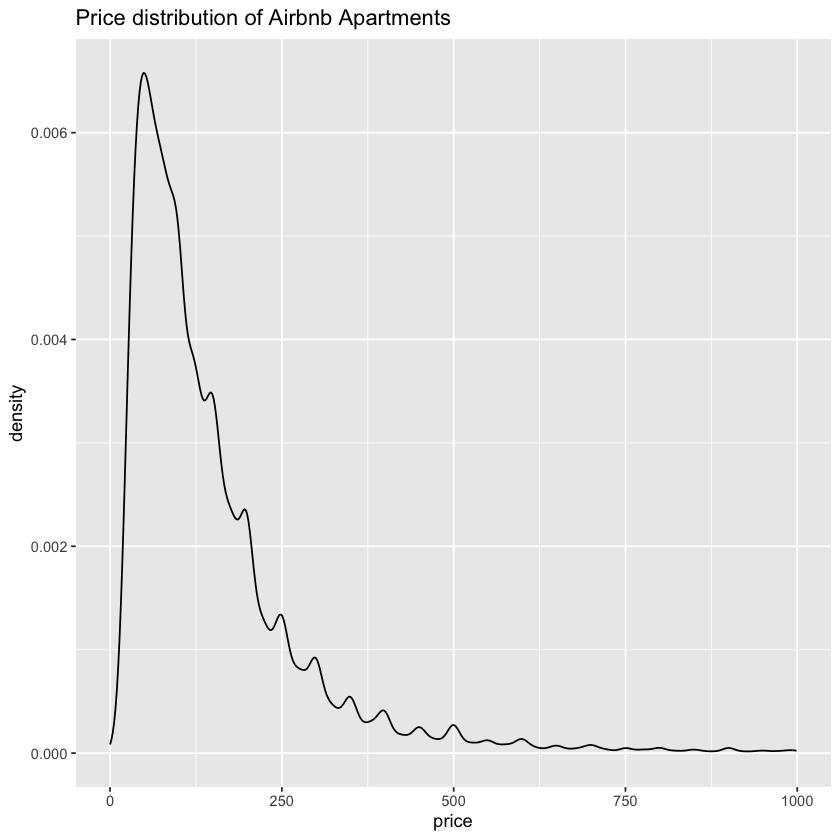

In [43]:
# Density curve
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = price)) +
  geom_density() +
  ggtitle("Price distribution of Airbnb Apartments")

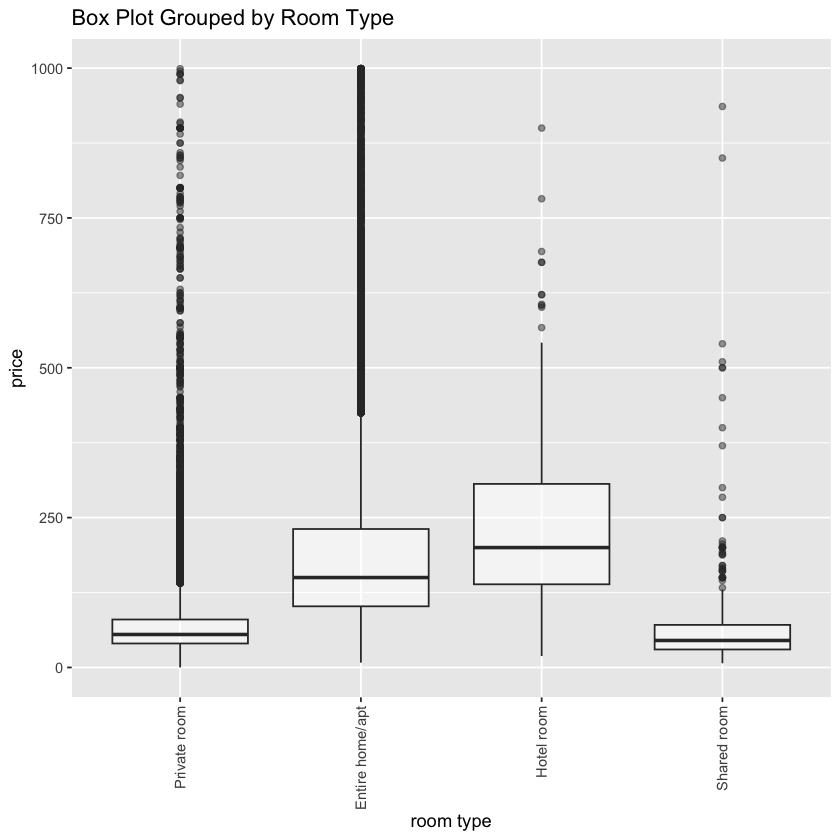

In [44]:

room_type_label <- c("Private room", "Entire home/apt", "Hotel room", "Shared room") # nolint

corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = as.factor(room_type), y = price)) +
  geom_boxplot(alpha = 0.5) +
  ggtitle("Box Plot Grouped by Room Type") +
  xlab("room type") +
  scale_x_discrete(labels = room_type_label) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

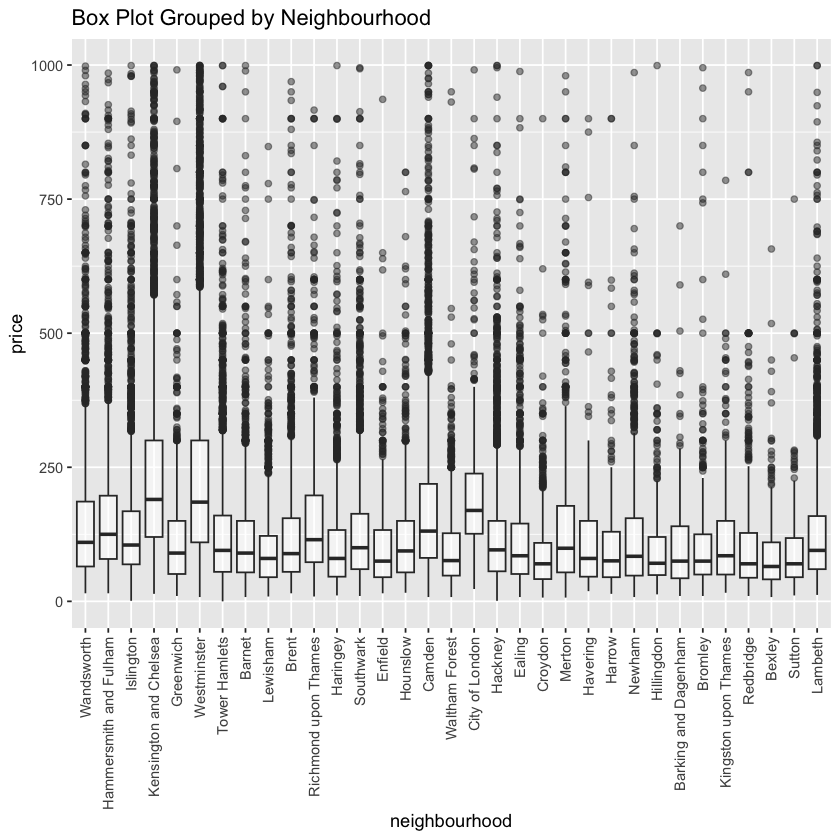

In [45]:
neighbourhood_label <- c("Wandsworth", "Hammersmith and Fulham", "Islington", "Kensington and Chelsea", "Greenwich", "Westminster", "Tower Hamlets", "Barnet", "Lewisham", "Brent", "Richmond upon Thames", "Haringey", "Southwark", "Enfield", "Hounslow", "Camden", "Waltham Forest", "City of London", "Hackney", "Ealing", "Croydon", "Merton", "Havering", "Harrow", "Newham", "Hillingdon", "Barking and Dagenham", "Bromley", "Kingston upon Thames", "Redbridge", "Bexley", "Sutton", "Lambeth") # nolint

corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = as.factor(neighbourhood_cleansed), y = price)) + # nolint
  geom_boxplot(alpha = 0.5) +
  ggtitle("Box Plot Grouped by Neighbourhood") +
  xlab("neighbourhood")  +
  scale_x_discrete(labels = neighbourhood_label) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

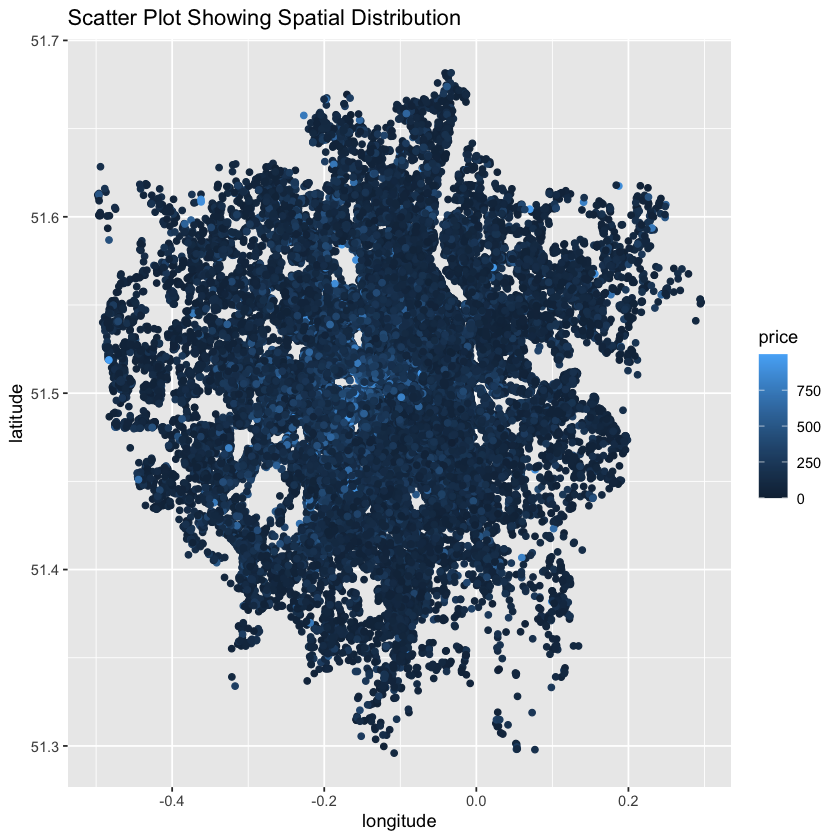

In [46]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = longitude, y = latitude, color = price)) +
  ggtitle("Scatter Plot Showing Spatial Distribution") +
  geom_point()

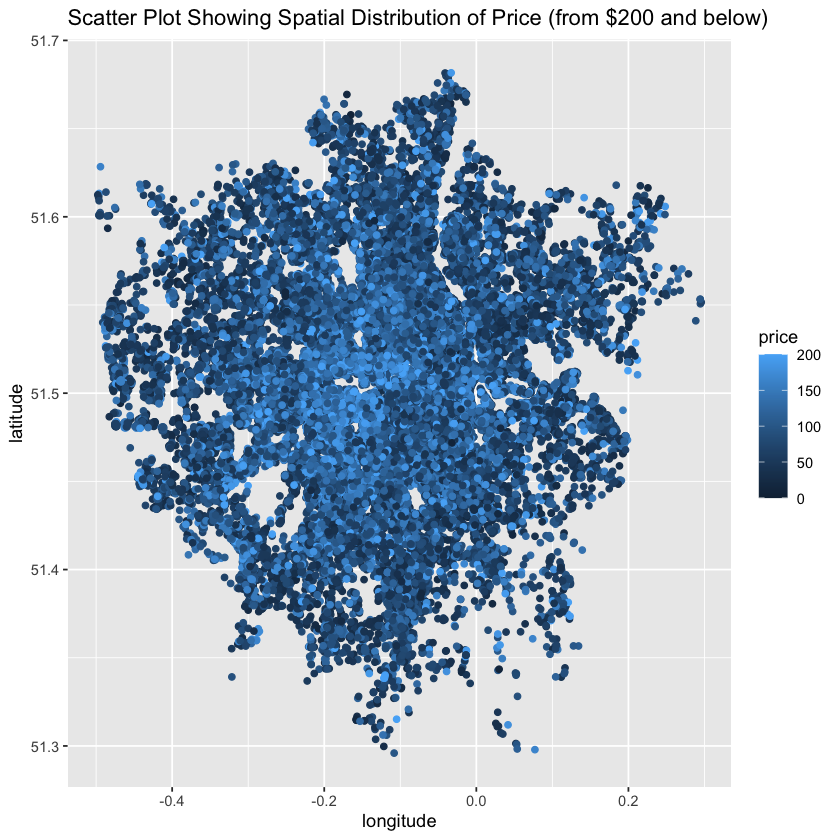

In [47]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price), price <= 200) %>%
  ggplot(aes(x = longitude, y = latitude, color = price)) +
  ggtitle("Scatter Plot Showing Spatial Distribution of Price (from $200 and below)") + # nolint
  geom_point()

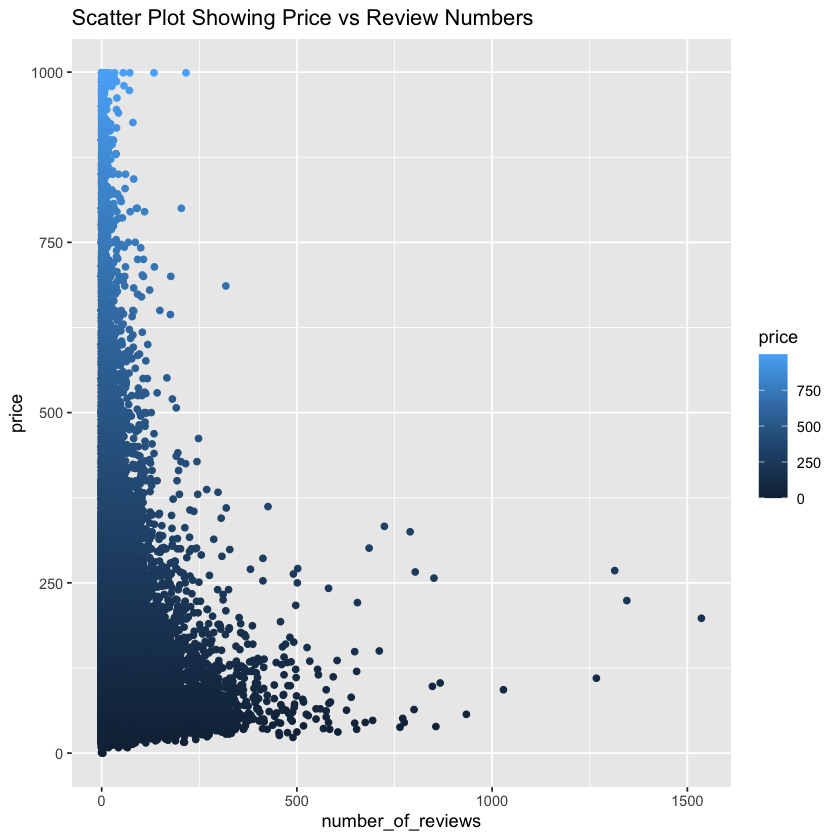

In [48]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = number_of_reviews, y = price, color = price)) +
  ggtitle("Scatter Plot Showing Price vs Review Numbers") +
  geom_point()

Warning message:
"Transformation introduced infinite values in continuous x-axis"


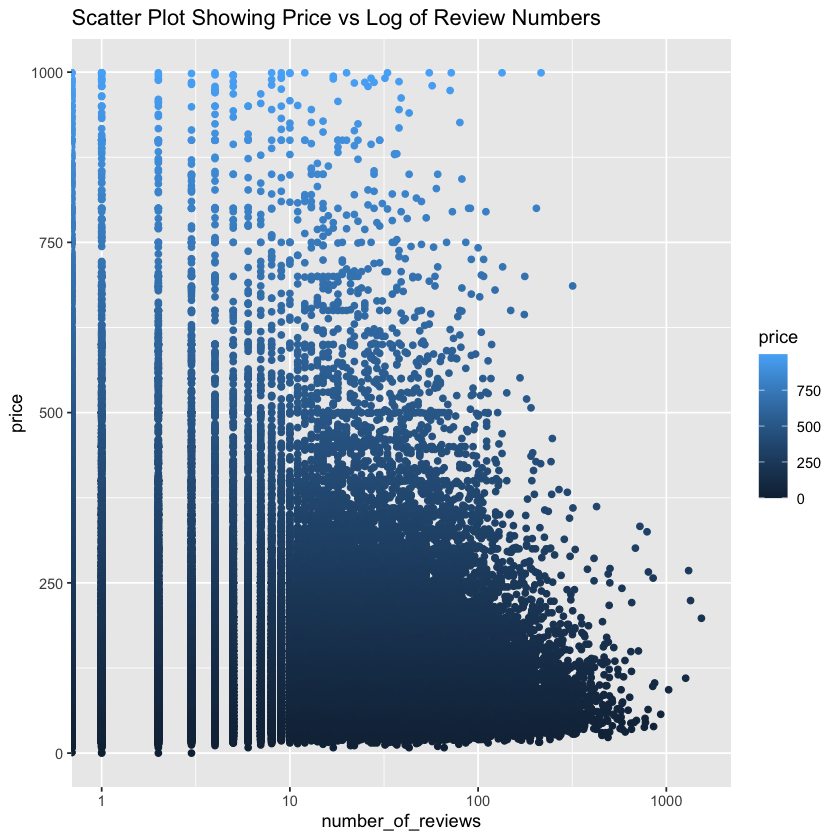

In [49]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = number_of_reviews, y = price, color = price)) + # nolint
  ggtitle("Scatter Plot Showing Price vs Log of Review Numbers") +
  geom_point() +
  scale_x_continuous(
    trans = "log10"
  )

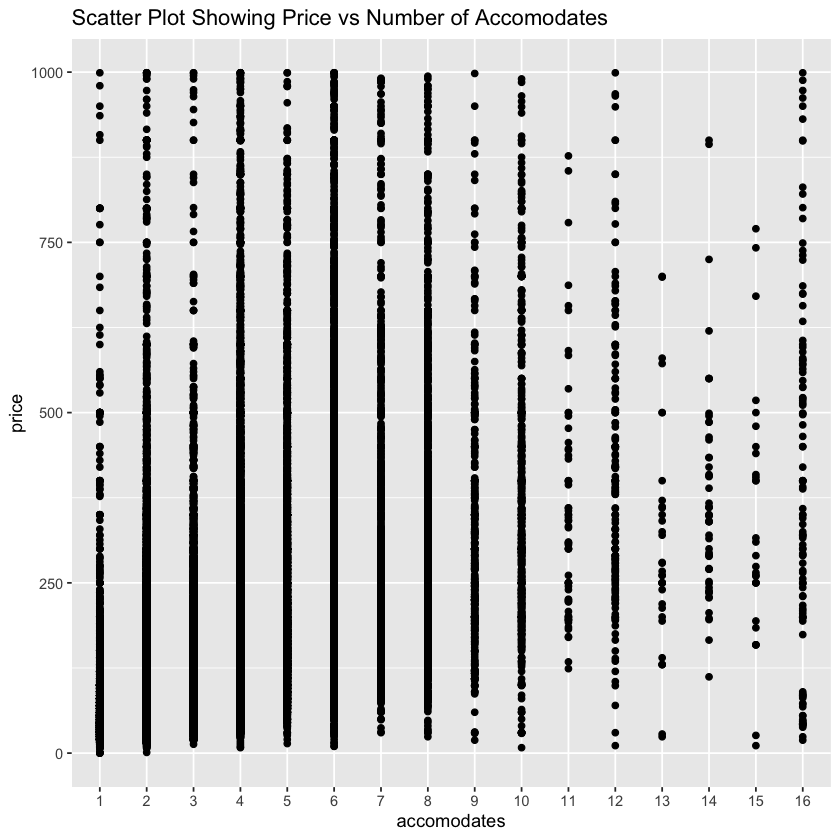

In [50]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = as.factor(accommodates), y = price)) +
  ggtitle("Scatter Plot Showing Price vs Number of Accomodates") +
  xlab("accomodates") +
  geom_point()

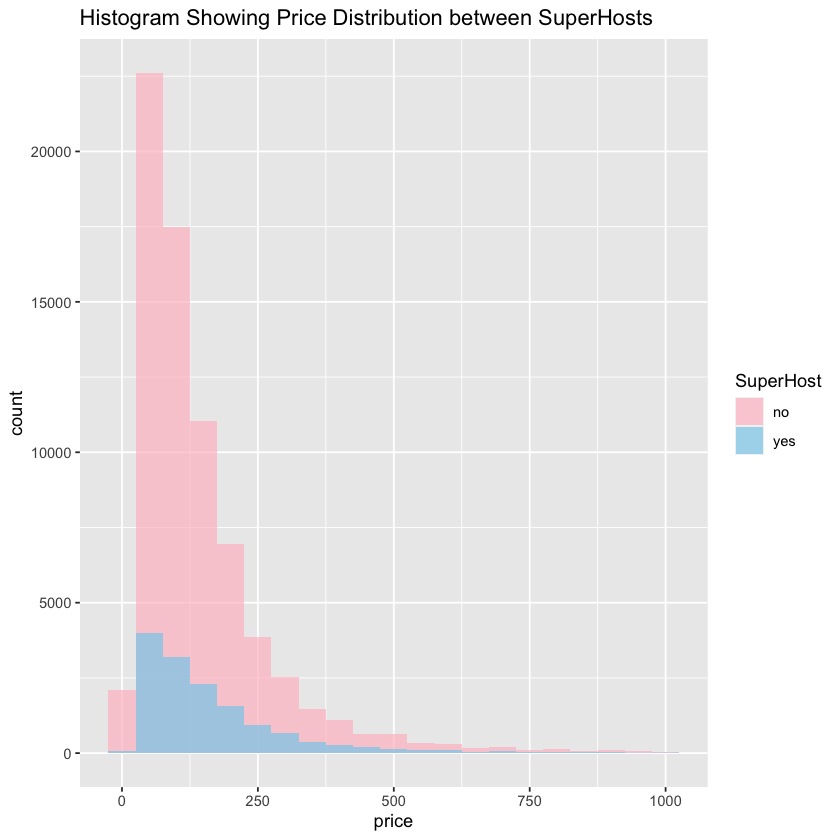

In [51]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = price, fill = as.factor(host_is_superhost))) +
  ggtitle("Histogram Showing Price Distribution between SuperHosts ") +
  scale_fill_manual(
                    name = "SuperHost",
                    values = c("pink", "skyblue"),
                    labels = c("no", "yes")) +
  geom_histogram(binwidth = 50, position = "identity", alpha = 0.7)

## Feature Engineering

The aim of the model that will be built is to predict the quarterly revenue. Using the provides features, that can be attained using the availability_90 and the price columns. It would also be essential to have a column of the log of the reviews.

The availability_90 column in the dataset is called so as it stands for how many days the room is available in the next 90 days - which makes up a quarter on an average. So if a room is available 74 days, that means the room is occupied for 16 days (90-74).

 

In [52]:
corr_listings_dt <- corr_listings_dt %>%
  mutate(
    quarterly_revenue = price * (90 - availability_90),
    log_of_reviews = log(number_of_reviews + 1)
  )

head(corr_listings_dt)

host_is_superhost neighbourhood_cleansed latitude longitude room_type
1 0                 1                      51.44201 -0.18739  1        
2 0                 2                      51.49993 -0.21707  2        
3 0                 3                      51.56861 -0.11270  1        
4 0                 4                      51.48780 -0.16813  2        
5 1                 5                      51.47618  0.01442  1        
6 1                 6                      51.52195 -0.14094  2        
  accommodates price minimum_nights maximum_nights availability_90
1 2             42   2              730             0             
2 5            175   5              240            38             
3 1             79   1               29            85             
4 2            150   7               30             7             
5 2             46   4              365             5             
6 6            476   3              365            50             
  number_of_reviews quarterly_revenue log_of_reviews
1 216                3780             5.379897      
2  38                9100             3.663562      
3  41                 395             3.737670      
4  94               12450             4.553877      
5 180                3910             5.198497      
6  54               19040             4.007333

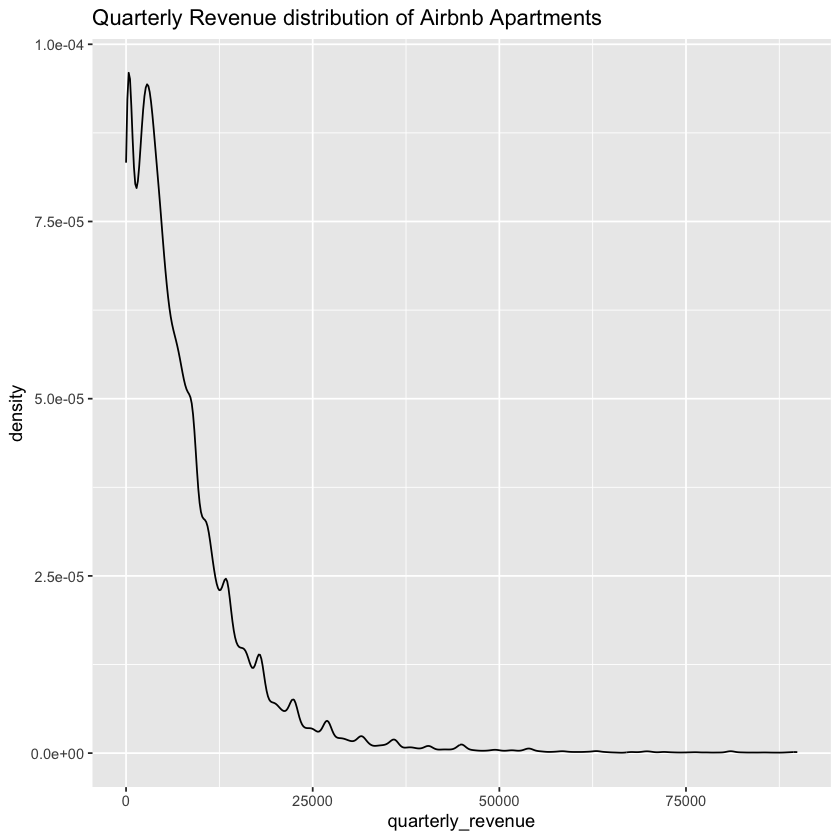

In [53]:
# Density curve
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = quarterly_revenue)) +
  geom_density() +
  ggtitle("Quarterly Revenue distribution of Airbnb Apartments")

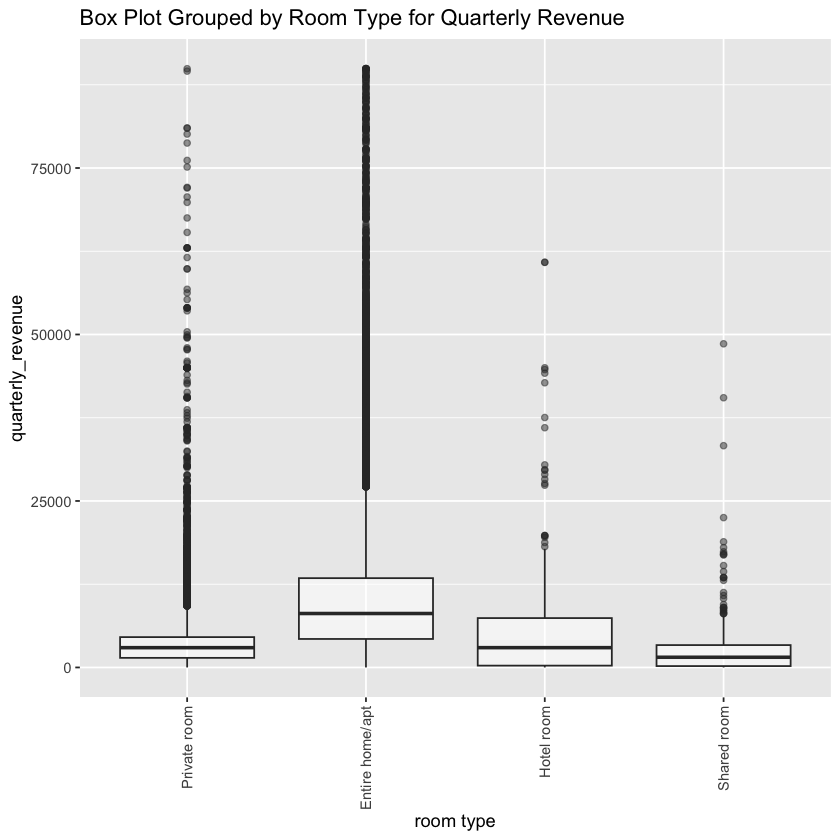

In [54]:

corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = as.factor(room_type), y = quarterly_revenue)) +
  geom_boxplot(alpha = 0.5) +
  ggtitle("Box Plot Grouped by Room Type for Quarterly Revenue") +
  xlab("room type") +
  scale_x_discrete(labels = room_type_label) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

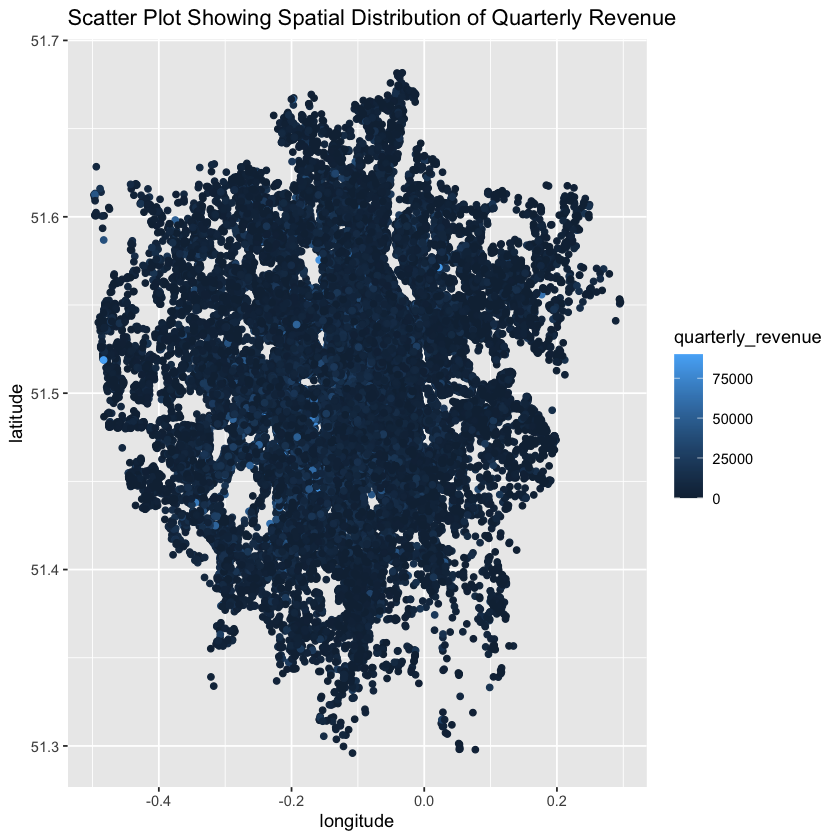

In [55]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = longitude, y = latitude, color = quarterly_revenue)) +
  ggtitle("Scatter Plot Showing Spatial Distribution of Quarterly Revenue") +
  geom_point()

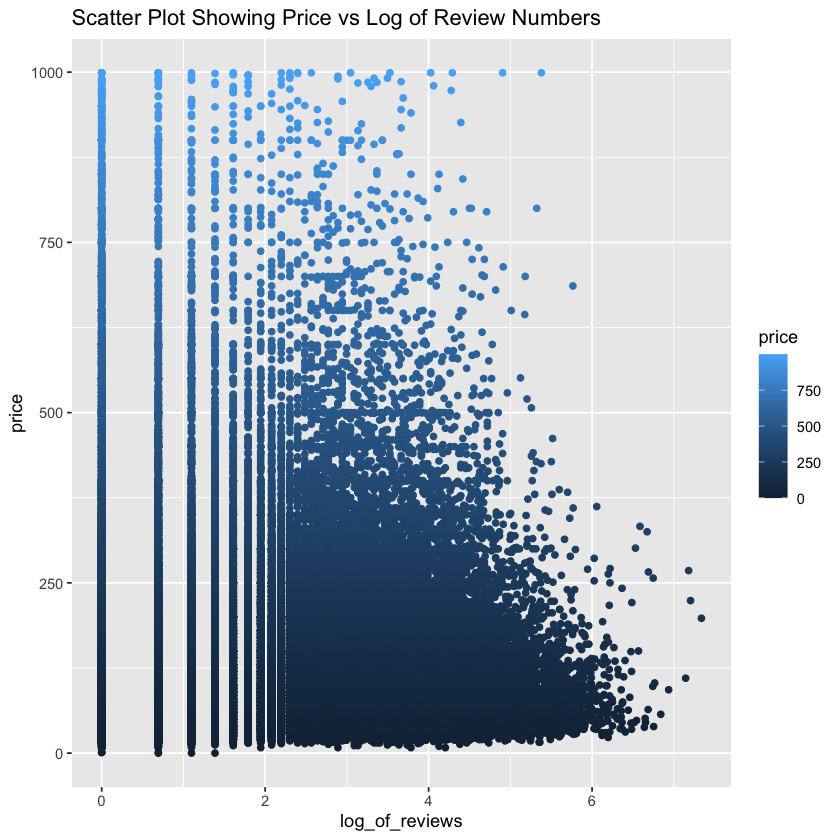

In [56]:
# basic scatterplot
corr_listings_dt %>%
  filter(!is.na(price)) %>%
  ggplot(aes(x = log_of_reviews, y = price, color = price)) + # nolint
  ggtitle("Scatter Plot Showing Price vs Log of Review Numbers") +
  geom_point()

In [57]:
# 80% of sample size
smp_size <- floor(0.8 * nrow(corr_listings_dt))

## set the seed to make your partition reproducible
set.seed(20)
train_ind <- sample(seq_len(nrow(corr_listings_dt)), size = smp_size)

train <- corr_listings_dt[train_ind, ]
test <- corr_listings_dt[-train_ind, ]

In [58]:
# Calculate the correlation matrix
cor_matrix <- cor(train[, .(host_is_superhost, neighbourhood_cleansed, latitude, longitude, room_type, accommodates, price, minimum_nights, maximum_nights, availability_90, number_of_reviews, quarterly_revenue, log_of_reviews)], use = "complete.obs") # nolint

print(cor_matrix)

                       host_is_superhost neighbourhood_cleansed     latitude
host_is_superhost            1.000000000           -0.014914862 -0.018236697
neighbourhood_cleansed      -0.014914862            1.000000000 -0.113738689
latitude                    -0.018236697           -0.113738689  1.000000000
longitude                   -0.028593596            0.161804931  0.093723141
room_type                   -0.033774149           -0.101717157 -0.004424322
accommodates                 0.004722371           -0.044378593 -0.013096980
price                        0.055659035           -0.164970972 -0.013205240
minimum_nights              -0.004588020           -0.027113145  0.004411029
maximum_nights              -0.001722733            0.003952112 -0.008148928
availability_90              0.089659386            0.026172384 -0.013202436
number_of_reviews            0.236834804           -0.009957152 -0.007942555
quarterly_revenue            0.022403134           -0.127167873 -0.014616088

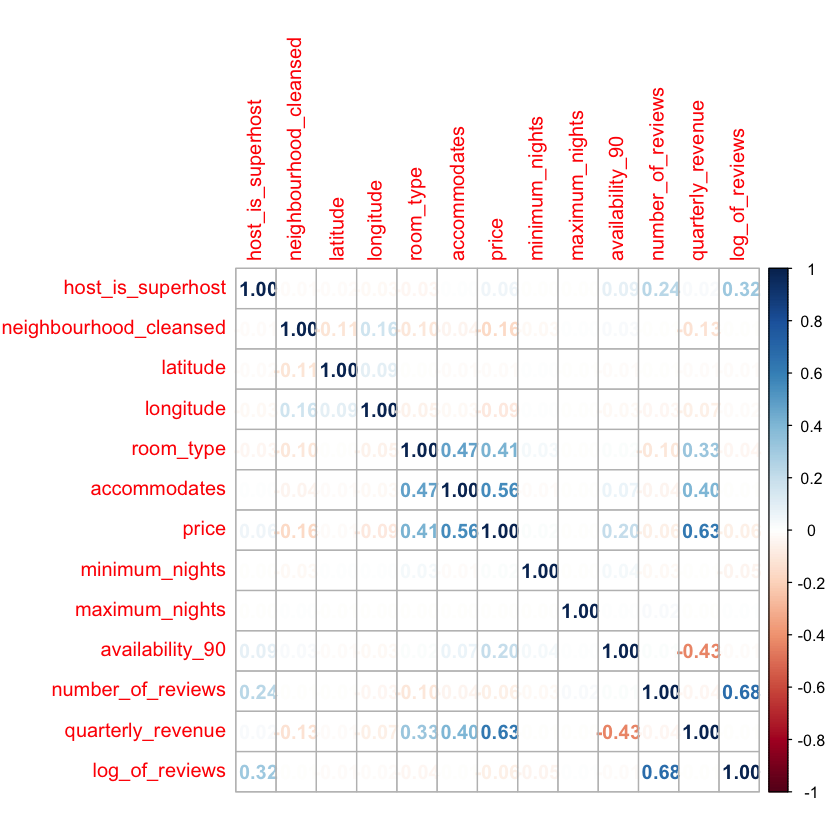

In [59]:
corrplot(cor_matrix, method = "number")

## Model Building

### Divide Data into Training and Testing and Train the Model

Training the model involved spliting it to training and testing data, with the trainig data having 80% of the dataset. The essence of the strata was to ensure the data is split proportionally across categorical lines.


In [60]:
corr_listings_split <- corr_listings_dt  %>%
  initial_split(corr_listings_dt, prop = 0.8, strata = room_type)

listings_train <- training(corr_listings_split)
listings_test <- testing(corr_listings_split)

#### Linear Regression Model Specification (regression)

- Computational engine: lm 

In [61]:
linear_model_specification <- linear_reg() %>%
  set_engine(engine = "lm")

linear_model_fit <- linear_model_specification %>%
  fit(quarterly_revenue ~ .,
      data = listings_train)

linear_model_fit

parsnip model object


Call:
stats::lm(formula = quarterly_revenue ~ ., data = data)

Coefficients:
           (Intercept)       host_is_superhost  neighbourhood_cleansed  
             8.083e+04               6.173e+02               1.241e+01  
              latitude               longitude               room_type  
            -1.503e+03              -1.256e+03               5.076e+02  
          accommodates                   price          minimum_nights  
             1.125e+02               4.862e+01               1.794e+00  
        maximum_nights         availability_90       number_of_reviews  
             9.743e-06              -1.510e+02              -1.805e+00  
        log_of_reviews  
             1.850e+02  


#### Random Forest Model Specification (regression)

- Computational engine: ranger 

In [62]:
random_forest_specification <- rand_forest(mode = "regression") %>%
  set_engine("ranger")

random_forest_fit <- random_forest_specification %>%
  fit(quarterly_revenue ~ .,
      data = listings_train)

random_forest_fit

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.threads = 1,      verbose = FALSE, seed = sample.int(10^5, 1)) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      68921 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       989069 
R squared (OOB):                  0.9873197 

## Model Evaluation

### Evaluation of the Training Data

Evaluate how the two models used - Linear Model and Random Forest Model, did on the training data.


In [63]:
model_evaluation_training_data <- linear_model_fit %>%
  predict(new_data = listings_train) %>%
  mutate(true_data = listings_train$quarterly_revenue,
         model = "lm") %>%
  bind_rows(random_forest_fit %>%
              predict(new_data = listings_train) %>%
              mutate(true_data = listings_train$quarterly_revenue,
                     model = "rf"))


model_evaluation_training_data

.pred      true_data model
1      -4275.460    395     lm   
2       6958.800   3910     lm   
3       6484.153   2610     lm   
4       7558.216   4500     lm   
5      -4827.049    385     lm   
6       7217.558   4950     lm   
7       8517.062   6120     lm   
8      -6148.588     55     lm   
9      -4568.147      0     lm   
10      8089.652   4950     lm   
11     -5127.203     55     lm   
12      6786.101   3780     lm   
13      6292.595   2250     lm   
14     12835.703  13500     lm   
15     -1408.640   1691     lm   
16      6145.792   3330     lm   
17      5102.906   4485     lm   
18     10385.988  11250     lm   
19     -6925.068      0     lm   
20     -6049.636    225     lm   
21      1649.639   1750     lm   
22      7781.787   5220     lm   
23      2345.438   2862     lm   
24      -794.494   1932     lm   
25      8008.775   6083     lm   
26      8950.301   5400     lm   
27      8649.017   7200     lm   
28      7756.356   6800     lm   
29     -6085.928    106     lm   
30      6755.741   5760     lm   
...    ...        ...       ...  
137813  1412.2366  1302     rf   
137814   144.4708     0     rf   
137815  4236.9853  4247     rf   
137816  4827.0444  4662     rf   
137817  9820.6074  9696     rf   
137818 12078.0772 11752     rf   
137819  4859.2153  4788     rf   
137820  1906.0637  1960     rf   
137821 11746.1412 11550     rf   
137822  2141.5987  2030     rf   
137823   222.0767   160     rf   
137824   142.1183     0     rf   
137825  2141.9730  1404     rf   
137826   162.9405     0     rf   
137827  1661.6517  1612     rf   
137828   723.2749   400     rf   
137829  6897.9546  6784     rf   
137830   558.3116   209     rf   
137831  2128.8457  2189     rf   
137832  2611.6353  2507     rf   
137833   178.1283   162     rf   
137834   178.2965   162     rf   
137835   170.2131   160     rf   
137836   522.5225   300     rf   
137837   341.8929   232     rf   
137838  4671.2015  4522     rf   
137839 21949.4131 21725     rf   
137840   469.9662   290     rf   
137841  1585.9365   680     rf   
137842   651.0845   510     rf

### Evaluation of the Test Data

Evaluate how the two models used - Linear Model and Random Forest Model, did on the test data.

In [64]:

model_evaluation_testing_data <- linear_model_fit %>%
  predict(new_data = listings_test) %>%
  mutate(true_data = listings_test$quarterly_revenue,
         model = "lm") %>%
  bind_rows(random_forest_fit %>%
              predict(new_data = listings_test) %>%
              mutate(true_data = listings_test$quarterly_revenue,
                     model = "rf"))

model_evaluation_testing_data

.pred       true_data model
1      7122.29150  3780     lm   
2     22170.25773 19040     lm   
3     -1517.86168     0     lm   
4      1250.78659  2970     lm   
5      5247.63767  5618     lm   
6      6724.74379  6960     lm   
7      8253.92601  6970     lm   
8     11907.24037 11130     lm   
9      6605.18350  3400     lm   
10    -2290.94394  1080     lm   
11    12980.67712 12600     lm   
12    13808.77127 15300     lm   
13     4494.31476  4080     lm   
14     7848.04830  5400     lm   
15     8733.35677  9450     lm   
16    15365.66316 18450     lm   
17    17923.15423 22500     lm   
18    13060.50093 13500     lm   
19     4226.76790  1463     lm   
20    11063.93006 11094     lm   
21    -1875.13162  1560     lm   
22    17801.49513 23670     lm   
23    -1801.74807   924     lm   
24     9873.35605  8170     lm   
25       22.17938   745     lm   
26     4711.70062  3740     lm   
27     1442.62921  1740     lm   
28     7696.16394  4950     lm   
29    -5091.37244   140     lm   
30    33175.32570 51480     lm   
...   ...         ...       ...  
34433 15247.6812  14700     rf   
34434   493.4342    336     rf   
34435  6763.3975   6320     rf   
34436   330.8418    140     rf   
34437  1984.9017   1445     rf   
34438  3986.7487   3995     rf   
34439  1049.2611    900     rf   
34440   408.0168      0     rf   
34441  1147.8052   1155     rf   
34442  1673.8552   1352     rf   
34443   436.5193    128     rf   
34444 23113.6501  23982     rf   
34445   840.4574    756     rf   
34446  3890.5199   3674     rf   
34447   219.2182     92     rf   
34448  1477.8075   1264     rf   
34449  2397.1926   2320     rf   
34450   349.6720    199     rf   
34451   663.6999    300     rf   
34452  4830.1689   4524     rf   
34453  8717.9157   8528     rf   
34454  3911.9896   3720     rf   
34455   319.7014    140     rf   
34456  1335.4574    750     rf   
34457  7455.3205   7511     rf   
34458  3673.8965   3375     rf   
34459  1114.4466   1035     rf   
34460  5266.0484   5160     rf   
34461  7182.7460   6880     rf   
34462   181.8796    164     rf

### Measure Model Performance

In [65]:
model_evaluation_training_data %>%
  group_by(model) %>%
  rmse(truth = true_data, estimate = .pred)

model .metric .estimator .estimate
1 lm    rmse    standard   4635.865 
2 rf    rmse    standard    474.767

In [66]:
model_evaluation_testing_data %>%
  group_by(model) %>%
  rmse(truth = true_data, estimate = .pred)

model .metric .estimator .estimate
1 lm    rmse    standard   4582.8655
2 rf    rmse    standard    908.9568

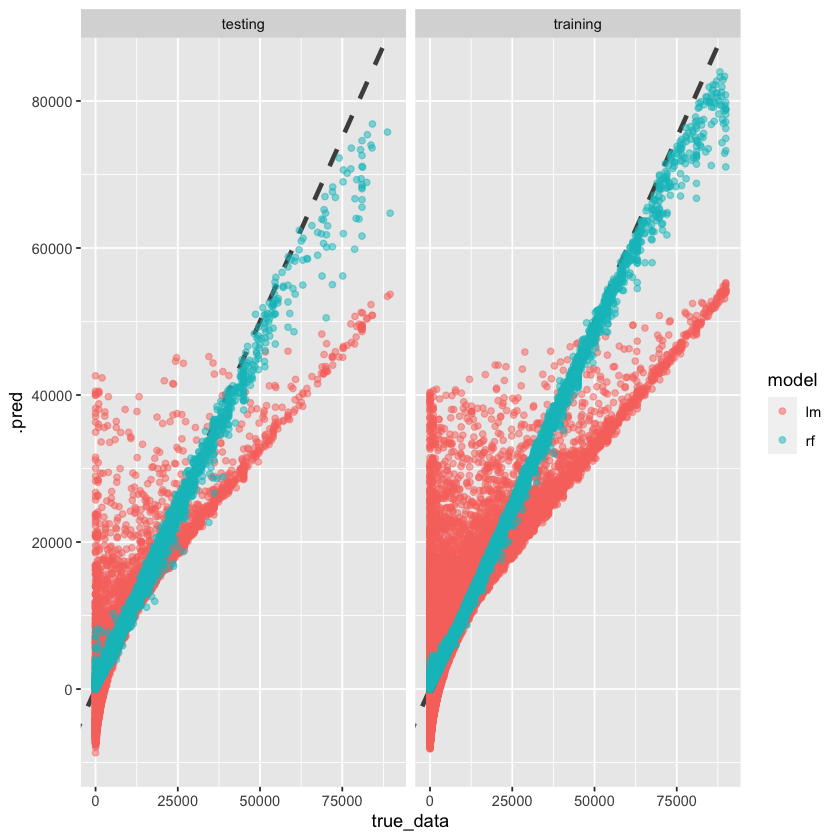

In [67]:
model_evaluation_testing_data %>%
  mutate(train = "testing") %>%
  bind_rows(model_evaluation_training_data %>%
              mutate(train = "training")) %>%
  ggplot(aes(true_data, .pred, color = model)) +
  geom_abline(lty = 2, color = "gray30", size = 1.3) +
  geom_point(alpha = 0.5) +
  facet_wrap(~train)


### Findings

- For the training data, the root mean squared error is significantly lower on the Random Forest Model than the Linear Regression Model, so the Random Forest Model did better.
- For the testing data, the root mean squared error is still significantly lower on the Random Forest Model than the Linear Regression Model, so the Random Forest Model did better again.
- For the Linear Model, the value of the root mean squared error are about the same, so there was no overfitting and the model should perform the about same way with any new data.
- For the Random Forest Model, the root mean squared error value is much higher on the testing data than on the training data.

### Resampling the Training Data

The point of resampling is to get a better estimate of how the model would perform on new data.

In [68]:
set.seed(200)
listing_folds <- vfold_cv(listings_train, strata = room_type)

rf_resample_results <- fit_resamples(
  random_forest_specification,
  quarterly_revenue ~ .,
  listing_folds,
  control = control_resamples(save_pred = TRUE)
)

In [69]:
rf_resample_results %>%
  collect_metrics()

.metric .estimator mean        n  std_err      .config             
1 rmse    standard   975.8367075 10 3.417502e+01 Preprocessor1_Model1
2 rsq     standard     0.9915541 10 5.045399e-04 Preprocessor1_Model1

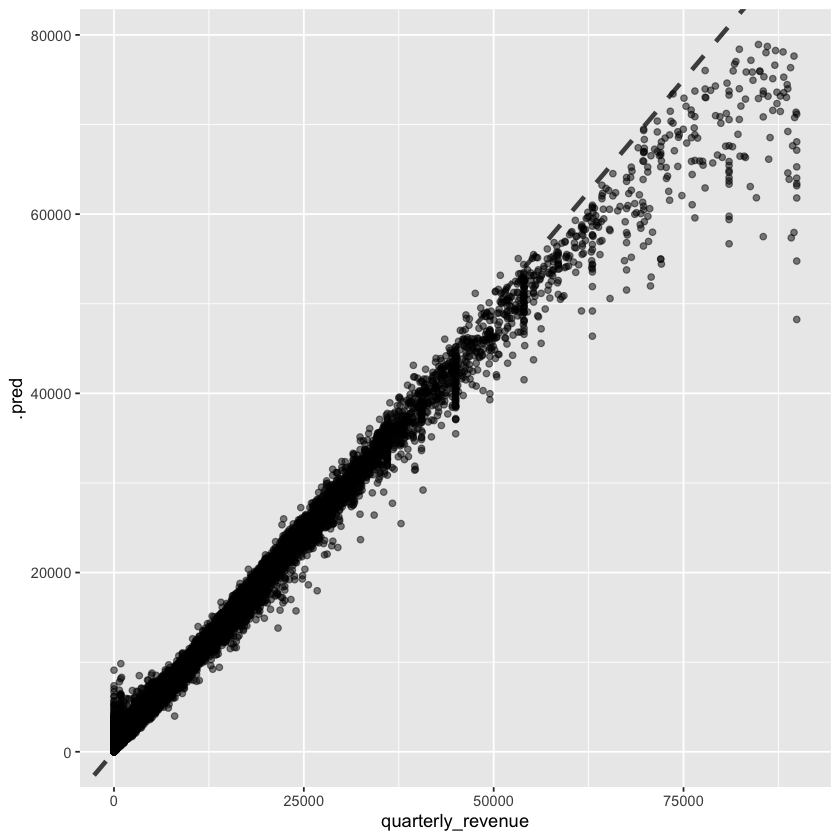

In [70]:
rf_resample_results %>%
  unnest(.predictions) %>%
  ggplot(aes(quarterly_revenue, .pred, colors = id)) +
  geom_abline(lty = 2, color = "gray30", size = 1.3) +
  geom_point(alpha = 0.5)

## Discussions

- For the training data, the root mean squared error is significantly lower on the Random Forest Model than the Linear Regression Model, so the Random Forest Model did better.
- For the testing data, the root mean squared error is still significantly lower on the Random Forest Model than the Linear Regression Model, so the Random Forest Model did better again.
- For the Linear Model, the value of the root mean squared error are about the same, so there was no overfitting and the model should perform the about same way with any new data.
- For the Random Forest Model, the root mean squared error value is much higher on the testing data than on the training data.